In [3]:
# установка библиотеки telebot
# pip install pyTelegramBotAPI

In [236]:
import os
import telebot
from telebot import types
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import psycopg2
import psycopg2.extras
import requests
from bs4 import BeautifulSoup

In [238]:
bot = telebot.TeleBot(os.environ['Telegram'])

In [239]:
def get_data_from_postgres(table):
    query = '''select *
from {}
    '''.format(table)
    conn = psycopg2.connect("dbname='quest-db' user='rouser' host='178.62.242.91' password='ZI6MVnmi' port=5433")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

In [240]:
def others(name):
    currency_new = pd.DataFrame(columns = ['currency', 'value'])
    link = 'https://www.google.com/search?q=' + str(name) + '+%D0%B2%D0%B0%D0%BB%D1%8E%D1%82%D0%B0'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'}
    full_page = requests.get(link, headers=headers)
    soup = BeautifulSoup(full_page.content, 'html.parser')
    if name != 'KRW':
        convert = soup.findAll("span", {"class": "DFlfde", "class": "SwHCTb", "data-precision": 2})
        currency_new.loc[len(currency_new)] = [name, convert[0].text.replace(",", ".")]
    else:
        convert = soup.findAll("span", {"class": "DFlfde", "class": "SwHCTb", "data-precision": 3})
        currency_new.loc[len(currency_new)] = [name, convert[0].text.replace(",", ".")]
    return pd.concat([currency, currency_new], ignore_index = True)

In [241]:
currency = pd.DataFrame(columns = ['currency', 'value'])

In [244]:
managers = {'Менеджер 1': 123456, 'Менеджер 2': 654321}
name =''
age = 0;
@bot.message_handler(commands=['start'])
def start_message(message):
  bot.send_message(message.chat.id,"Привет! Для начала использования бота введи, пожалуйста, свой логин")
@bot.message_handler(content_types=['text'])
def start(message):
    if message.text in managers:
        global name
        name = message.text
        bot.send_message(message.from_user.id, "Спасибо, " + str(name) + ". Напиши свой пароль")
        bot.register_next_step_handler(message, get_password)
    else:
        bot.send_message(message.from_user.id, 'Неверный логин. Попробуйте, пожалуйста, еще раз или начните сначала командой /start')

def get_password(message):
    global name;
    if str(kek[name]) == message.text:
        keyboard = types.InlineKeyboardMarkup()
        key_metric1 = types.InlineKeyboardButton(text='Конверсия', callback_data='first_metric1')
        keyboard.add(key_metric1)
        key_metric2= types.InlineKeyboardButton(text='Динамика количества пользователей', callback_data='first_metric2')
        keyboard.add(key_metric2)
        key_metric3= types.InlineKeyboardButton(text='Динамика выручки на 1 пользователя', callback_data='first_metric3')
        keyboard.add(key_metric3)
        question = "Отлично! Какую метрику тебе показать?"
        bot.send_message(message.from_user.id, text=question, reply_markup=keyboard)
    else: 
        bot.send_message(message.from_user.id, 'Некорректный пароль. Попробуйте, пожалуйста, еще раз или начните сначала командой /start')
        bot.register_next_step_handler(message, get_password)
@bot.callback_query_handler(func=lambda call: call.data.startswith('first'))
def callback_worker(call):
    if call.data == "first_metric1":
        keyboard = types.InlineKeyboardMarkup()
        key_conv1 = types.InlineKeyboardButton(text='Конверсия из заявки в покупку', callback_data='second_key_conv1')
        keyboard.add(key_conv1)
        key_conv2= types.InlineKeyboardButton(text='Конверсия из вводного урока в покупку', callback_data='second_key_conv2')
        keyboard.add(key_conv2)
        key_conv3= types.InlineKeyboardButton(text='Конверсия из демо урока в покупку', callback_data='second_key_conv3')
        keyboard.add(key_conv3)
        question = "Выберите тип конверсии"
        bot.send_message(call.message.chat.id, text=question, reply_markup=keyboard)
    elif call.data == "first_metric2":
        keyboard = types.InlineKeyboardMarkup()
        key_dyn1 = types.InlineKeyboardButton(text='Динамика всех юзеров', callback_data='second_key_dyn1')
        keyboard.add(key_dyn1)
        key_dyn2= types.InlineKeyboardButton(text='Динамика юзеров с покупкой', callback_data='second_key_dyn2')
        keyboard.add(key_dyn2)
        question = "Выберите тип динамики"
        bot.send_message(call.message.chat.id, text=question, reply_markup=keyboard)
    elif call.data == "first_metric3":
        payments = pd.DataFrame(get_data_from_postgres('payments'))
        for name in payments[payments['currency']!= 'RUB']['currency'].unique():
            currency = others(name)
        payments = payments.merge(currency, how = 'left', on = 'currency')
        payments['amount'] = payments['amount'].astype(float)
        payments['value'] = payments['value'].astype(float)
        payments.loc[payments['currency'] != 'RUB', 'amount'] = round(payments['amount'] * payments['value'])
        payments['transaction_created_at'] = pd.to_datetime(payments['transaction_created_at'])
        metric1 = payments.groupby(by = [payments['transaction_created_at'].dt.strftime('%Y-%m')]).agg({'_user_id':'nunique', 'amount': 'sum'}).reset_index()
        metric1['amount per user'] = metric1['amount'] / metric1['_user_id']
        plt.figure(figsize=(18, 8))
        chart = sns.barplot(x=metric1['transaction_created_at'], y=metric1['amount per user'])
        chart.set_title('Динамика прибыли с 1 пользователя, руб', fontdict={'fontsize':12}, pad=12);
        plt.xlabel('Месяц')
        plt.ylabel('Прибыль с одного пользователя')
        for p in chart.patches:
             chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
        plt.savefig('Динамика выручки.png', dpi=300, bbox_inches='tight')
        img = open('Динамика выручки.png', 'rb')
        bot.send_photo(call.message.chat.id, img)
    else:
        bot.send_message(call.message.chat.id, 'Выберите метрику из списка или начните сначала командой /start')
@bot.callback_query_handler(func=lambda call: call.data.startswith('second'))      
def callback_worker2(call):
    if call.data == "second_key_conv1":
        payments = pd.DataFrame(get_data_from_postgres('payments'))
        events = pd.DataFrame(get_data_from_postgres('events'))
        events_dict = pd.DataFrame(get_data_from_postgres('events_dict'))
        events_dict.drop(['pk', '_index', '_name'], axis = 1, inplace = True)
        events.drop(['pk'], axis = 1, inplace = True)
        events_dict.rename(columns = {'id': 'event_id'}, inplace = True)
        events = events.merge(events_dict, how = 'left', on = 'event_id')
        events['happened_at'] = pd.to_datetime(events['happened_at'])
        events = events.drop(columns=['event_id'])
        for_events = payments[['transaction_created_at', '_user_id']]
        for_events.loc[:, '_description'] = 'Покупка'
        for_events = for_events.rename(columns = {'transaction_created_at':'happened_at'})
        events = pd.concat([events, for_events], ignore_index = True)
        events.sort_values(by=['_user_id','happened_at'], ascending=True, inplace=True)
        kpi = events[events['_description']== 'Покупка']['_user_id'].nunique() / events['_user_id'].nunique()
        bot.send_message(call.message.chat.id, f'Конверсия из заявки в оплату составила: {kpi:.2%}')
    elif call.data == "second_key_conv2":
        payments = pd.DataFrame(get_data_from_postgres('payments'))
        events = pd.DataFrame(get_data_from_postgres('events'))
        events_dict = pd.DataFrame(get_data_from_postgres('events_dict'))
        events_dict.drop(['pk', '_index', '_name'], axis = 1, inplace = True)
        events.drop(['pk'], axis = 1, inplace = True)
        events_dict.rename(columns = {'id': 'event_id'}, inplace = True)
        events = events.merge(events_dict, how = 'left', on = 'event_id')
        events['happened_at'] = pd.to_datetime(events['happened_at'])
        events = events.drop(columns=['event_id'])
        events = events[events['_description'] == 'Успешный ВУ']
        for_events = payments[['transaction_created_at', '_user_id']]
        for_events = for_events.drop(columns=['transaction_created_at']).drop_duplicates()
        for_events.loc[:, 'Купил'] = 'Да'
        events = events.merge(for_events, how = 'left', on = '_user_id')
        kpi = events[events['Купил']== 'Да']['_user_id'].nunique() / events[events['_description']== 'Успешный ВУ']['_user_id'].nunique()
        bot.send_message(call.message.chat.id, f'Конверсия из вводного урока в оплату составила: {kpi:.2%}')
    elif call.data == "second_key_conv3":
        payments = pd.DataFrame(get_data_from_postgres('payments'))
        events = pd.DataFrame(get_data_from_postgres('events'))
        events_dict = pd.DataFrame(get_data_from_postgres('events_dict'))
        events_dict.drop(['pk', '_index', '_name'], axis = 1, inplace = True)
        events.drop(['pk'], axis = 1, inplace = True)
        events_dict.rename(columns = {'id': 'event_id'}, inplace = True)
        events = events.merge(events_dict, how = 'left', on = 'event_id')
        events['happened_at'] = pd.to_datetime(events['happened_at'])
        events = events.drop(columns=['event_id'])
        events = events[events['_description'] == 'ДУ завершен']
        for_events = payments[['transaction_created_at', '_user_id']]
        for_events = for_events.drop(columns=['transaction_created_at']).drop_duplicates()
        for_events.loc[:, 'Купил'] = 'Да'
        events = events.merge(for_events, how = 'left', on = '_user_id')
        kpi = events[events['Купил']== 'Да']['_user_id'].nunique() / events[events['_description']== 'ДУ завершен']['_user_id'].nunique()
        bot.send_message(call.message.chat.id, f'Конверсия из демо урока в оплату составила: {kpi:.2%}')
    elif call.data == "second_key_dyn1":
        events = pd.DataFrame(get_data_from_postgres('events'))
        events['happened_at'] = pd.to_datetime(events['happened_at'])
        metric1 = events.groupby(by = [events['happened_at'].dt.strftime('%Y-%m')]).agg({'_user_id':'nunique'}).reset_index()
        metric1 = metric1[metric1['_user_id'] > 10]
        plt.figure(figsize=(18, 8))
        chart = sns.barplot(x=metric1['happened_at'], y=metric1['_user_id'])
        chart.set_title('Динамика количества всех пользователей за период, чел', fontdict={'fontsize':12}, pad=12);
        plt.xlabel('Месяц')
        plt.ylabel('Количество пользователей')
        for p in chart.patches:
             chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
        plt.savefig('Динамика всех пользователей.png', dpi=300, bbox_inches='tight')
        img = open('Динамика всех пользователей.png', 'rb')
        bot.send_photo(call.message.chat.id, img)
    elif call.data == "second_key_dyn2":
        payments = pd.DataFrame(get_data_from_postgres('payments'))
        payments['transaction_created_at'] = pd.to_datetime(payments['transaction_created_at'])
        metric1 = payments.groupby(by = [payments['transaction_created_at'].dt.strftime('%Y-%m')]).agg({'_user_id':'nunique'}).reset_index()
        metric1 = metric1[metric1['_user_id'] > 10]
        plt.figure(figsize=(18, 8))
        chart = sns.barplot(x=metric1['transaction_created_at'], y=metric1['_user_id'])
        chart.set_title('Динамика количества пользователей с оплатой за период, чел', fontdict={'fontsize':12}, pad=12);
        plt.xlabel('Месяц')
        plt.ylabel('Количество пользователей')
        for p in chart.patches:
             chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')
        plt.savefig('Динамика оплативших пользователей.png', dpi=300, bbox_inches='tight')
        img = open('Динамика оплативших пользователей.png', 'rb')
        bot.send_photo(call.message.chat.id, img)
    else:
        bot.send_message(call.message.chat.id, 'Выберите метрику из списка или начните сначала командой /start')     

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'Удаленный хост принудительно разорвал существующее подключение', None, 10054, None))

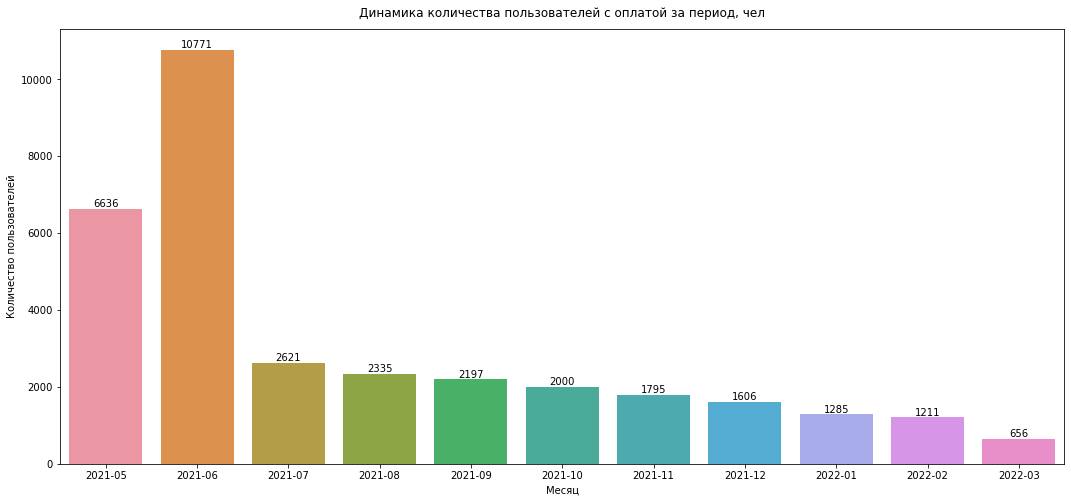

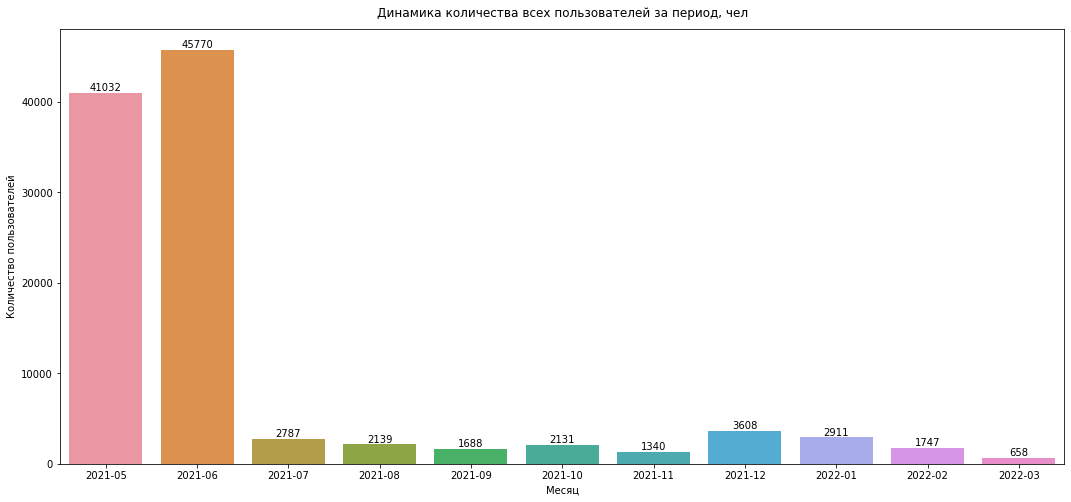

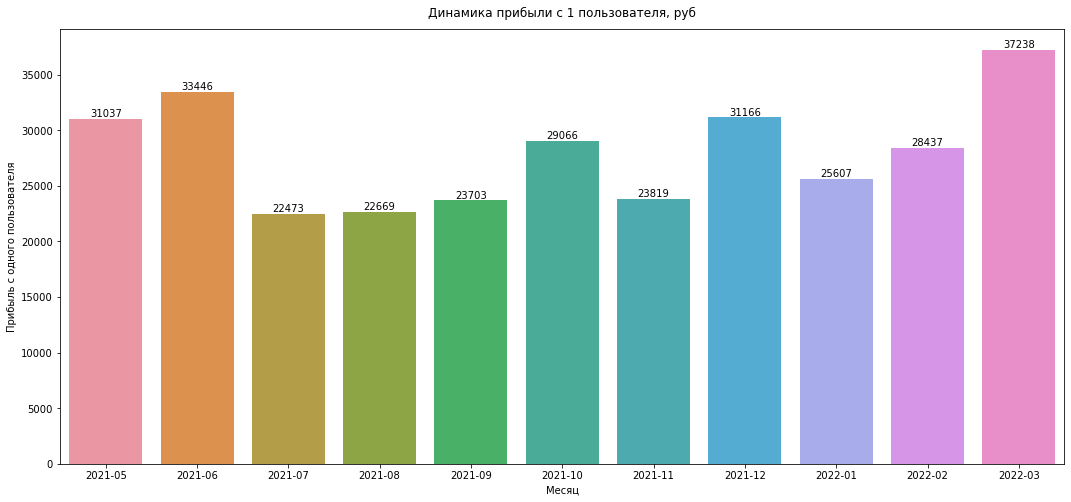

In [245]:
bot.polling(none_stop=True, interval=0)